Step 1: Imports

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

Step 2: Load and Explore the Dataset

In [2]:
# Load data
df = pd.read_csv("final_Naive.csv")

# Count the number of unique drivers for each label
num_normal_drivers = df[df['label'] == 0]['id'].nunique()
num_abnormal_drivers = df[df['label'] == 1]['id'].nunique()

print(f"Number of unique normal drivers (label 0): {num_normal_drivers}")
print(f"Number of unique abnormal drivers (label 1): {num_abnormal_drivers}")

Number of unique normal drivers (label 0): 161
Number of unique abnormal drivers (label 1): 7


Step 3: Select Drivers and Split Data

In [ ]:
# Select 7 normal and 5 abnormal drivers at random
num_normal_to_select = 7
num_abnormal_to_select = 5

selected_normal_drivers = np.random.choice(df[df['label'] == 0]['id'].unique(), num_normal_to_select, replace=False)
selected_abnormal_drivers = np.random.choice(df[df['label'] == 1]['id'].unique(), num_abnormal_to_select, replace=False)

# Get data for selected drivers
selected_normal_data = df[df['id'].isin(selected_normal_drivers)]
selected_abnormal_data = df[df['id'].isin(selected_abnormal_drivers)]

# Combine selected data
selected_data = pd.concat([selected_normal_data, selected_abnormal_data])

print(f"Selected normal drivers: {selected_normal_drivers}")
print(f"Selected abnormal drivers: {selected_abnormal_drivers}")

# Split each selected driver's data into training (30%) and testing (70%) sets
def split_driver_data(driver_data, train_size=0.3):
    train_data_list = []
    test_data_list = []
    
    for driver_id, group in driver_data.groupby('id'):
        train_data, test_data = train_test_split(group, train_size=train_size, random_state=42)
        train_data_list.append(train_data)
        test_data_list.append(test_data)
    
    train_data = pd.concat(train_data_list)
    test_data = pd.concat(test_data_list)
    
    return train_data, test_data

# Split the selected normal and abnormal data
train_normal_data, test_normal_data = split_driver_data(selected_normal_data)
train_abnormal_data, test_abnormal_data = split_driver_data(selected_abnormal_data)

# Combine normal and abnormal data for training and testing
train_data = pd.concat([train_normal_data, train_abnormal_data])
test_data = pd.concat([test_normal_data, test_abnormal_data])

print(f"Training data shape: {train_data.shape}")
print(f"Testing data shape: {test_data.shape}")

Selected normal drivers: ['05453059-3121-4c8f-8bb9-c08862b0ec94'
 '7e8f149f-e541-487a-9450-f417987baef8'
 '84217b56-dec9-42c3-a15c-e119c9ac5a5e'
 'af529229-5352-4d67-8876-26bbdb1cd817'
 '727b3944-343b-4492-a161-1a2f7c189794'
 '8661acc1-604f-4834-bc4c-d240dc386cc1']
Selected abnormal drivers: ['f615ca28-7fc1-4f95-a8e9-9fb97daecc54'
 'e157f7aa-206c-46a7-b35d-3026bcdccca8'
 '54b9e228-6901-458f-a067-6008bf806aae'
 'd9889429-d53d-4b07-b410-b84dd3eaa711'
 '1118cb0f-a610-479b-8ff1-e71cd0193a30']
Training data shape: (1768445, 11)
Testing data shape: (4126385, 11)


Step 4: Preprocess the Data for Simple NN

In [4]:
# Define feature columns for the Naive approach
FEATURE_COLS = ['lon', 'lat', 'kph2', 'sog', 'Distance_miles', 'azimuth']
segment_length = 200
total_features = len(FEATURE_COLS) * segment_length

# Function to preprocess data for simple neural network
def preprocess_naive_features(df, feature_cols, segment_length, total_features):
    flattened_segments_list, segment_labels = [], []
    for _, group in df.groupby('Segment'):
        segment_flat = group[feature_cols].values.flatten()
        if len(segment_flat) < total_features:
            segment_flat = np.pad(segment_flat, (0, total_features - len(segment_flat)), 'constant')
        elif len(segment_flat) > total_features:
            segment_flat = segment_flat[:total_features]
        flattened_segments_list.append(segment_flat)
        segment_labels.append(group['label'].iloc[0])
    return np.array(flattened_segments_list), np.array(segment_labels)

# Preprocess naive features
naive_segments, naive_labels = preprocess_naive_features(train_data, FEATURE_COLS, segment_length, total_features)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
naive_segments_imputed = imputer.fit_transform(naive_segments)

# Normalize features
scaler = StandardScaler()
naive_segments_scaled = scaler.fit_transform(naive_segments_imputed)

# Split dataset with stratification to maintain label distribution
X_train, X_val, y_train, y_val = train_test_split(
    naive_segments_scaled, naive_labels, test_size=0.2, stratify=naive_labels, random_state=42)

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_val, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Step 5: Define and Train the Simple NN Model

In [5]:
# Define a simple neural network architecture with slightly larger nodes
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer with 128 nodes
        self.fc2 = nn.Linear(128, 64)  # Second hidden layer with 64 nodes
        self.fc3 = nn.Linear(64, 32)   # Third hidden layer with 32 nodes
        self.fc4 = nn.Linear(32, 2)    # Output layer with 2 nodes (binary classification)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Training the simple neural network model
model = SimpleNN(input_size=X_train_tensor.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

# Training loop with F1-score monitoring
num_epochs = 30
f1_scores = []

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Evaluate F1-score at each epoch
    model.eval()
    with torch.no_grad():
        outputs = model(X_val_tensor.to(device))
        _, predictions = torch.max(outputs, 1)
    
    f1 = f1_score(y_val_tensor.cpu(), predictions.cpu())
    f1_scores.append(f1)
    print(f'Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}, F1 Score: {f1:.4f}')
    model.train()

Epoch 1, Loss: 0.5109418889222515, F1 Score: 0.8706
Epoch 2, Loss: 0.48391908063566236, F1 Score: 0.8729
Epoch 3, Loss: 0.47562137246131897, F1 Score: 0.8740
Epoch 4, Loss: 0.4695700292381093, F1 Score: 0.8735
Epoch 5, Loss: 0.4628868079327684, F1 Score: 0.8744
Epoch 6, Loss: 0.4519397009675119, F1 Score: 0.8759
Epoch 7, Loss: 0.4411483253120902, F1 Score: 0.8748
Epoch 8, Loss: 0.4283000971551681, F1 Score: 0.8764
Epoch 9, Loss: 0.41614257233221064, F1 Score: 0.8744
Epoch 10, Loss: 0.40614300708529016, F1 Score: 0.8732
Epoch 11, Loss: 0.3978101145290949, F1 Score: 0.8789
Epoch 12, Loss: 0.38894247736181936, F1 Score: 0.8814
Epoch 13, Loss: 0.3793020994359883, F1 Score: 0.8762
Epoch 14, Loss: 0.3712064208792408, F1 Score: 0.8879
Epoch 15, Loss: 0.36182242968151157, F1 Score: 0.8842
Epoch 16, Loss: 0.3531896502638669, F1 Score: 0.8802
Epoch 17, Loss: 0.34916483819721705, F1 Score: 0.8883
Epoch 18, Loss: 0.3432286790096262, F1 Score: 0.8847
Epoch 19, Loss: 0.3378586461749039, F1 Score: 0.

Final Precision on Validation Set: 0.8536
Final Recall on Validation Set: 0.9248
Final F1 Score on Validation Set: 0.8878


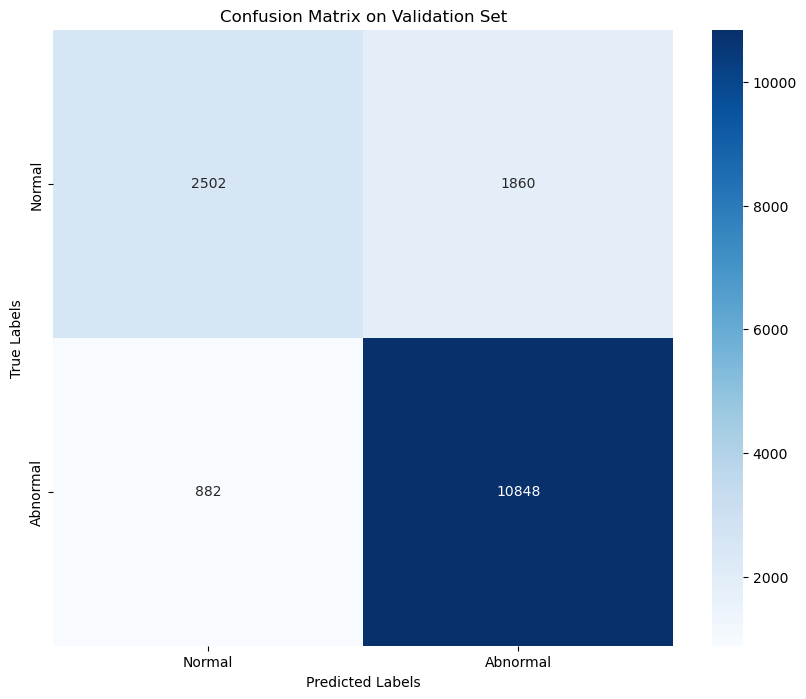

In [6]:
# Evaluate the final model on the validation set
model.eval()
with torch.no_grad():
    outputs = model(X_val_tensor.to(device))
    _, predictions = torch.max(outputs, 1)

# Metrics
precision = precision_score(y_val_tensor.cpu(), predictions.cpu())
recall = recall_score(y_val_tensor.cpu(), predictions.cpu())
f1 = f1_score(y_val_tensor.cpu(), predictions.cpu())

print(f'Final Precision on Validation Set: {precision:.4f}')
print(f'Final Recall on Validation Set: {recall:.4f}')
print(f'Final F1 Score on Validation Set: {f1:.4f}')

# Confusion Matrix on Validation Set
cm_val = confusion_matrix(y_val_tensor.cpu(), predictions.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Validation Set')
plt.show()

Step 6: Test on Full Dataset

Final Precision on Test Set: 0.7851
Final Recall on Test Set: 0.8831
Final F1 Score on Test Set: 0.8312


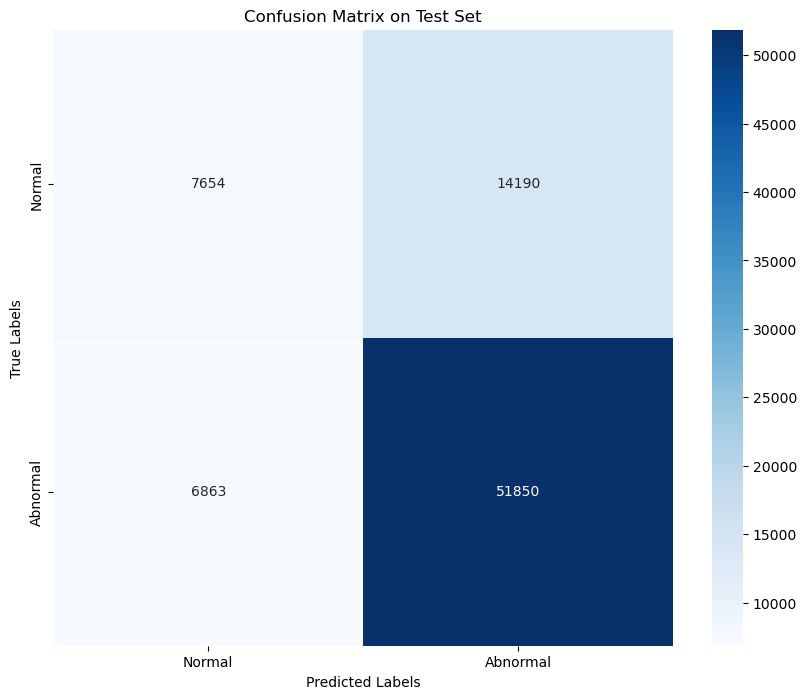

In [7]:
# Preprocess test data for Naive approach
test_naive_segments, test_naive_labels = preprocess_naive_features(test_data, FEATURE_COLS, segment_length, total_features)

# Impute missing values with mean
test_naive_segments_imputed = imputer.transform(test_naive_segments)

# Normalize features
test_naive_segments_scaled = scaler.transform(test_naive_segments_imputed)

# Convert to tensors
X_test_tensor = torch.tensor(test_naive_segments_scaled, dtype=torch.float)
y_test_tensor = torch.tensor(test_naive_labels, dtype=torch.long)

# Evaluate the final model on the test set
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor.to(device))
    _, predictions = torch.max(outputs, 1)

# Metrics
precision_test = precision_score(y_test_tensor.cpu(), predictions.cpu())
recall_test = recall_score(y_test_tensor.cpu(), predictions.cpu())
f1_test = f1_score(y_test_tensor.cpu(), predictions.cpu())

print(f'Final Precision on Test Set: {precision_test:.4f}')
print(f'Final Recall on Test Set: {recall_test:.4f}')
print(f'Final F1 Score on Test Set: {f1_test:.4f}')

# Confusion Matrix on Test Set
cm_test = confusion_matrix(y_test_tensor.cpu(), predictions.cpu())
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()

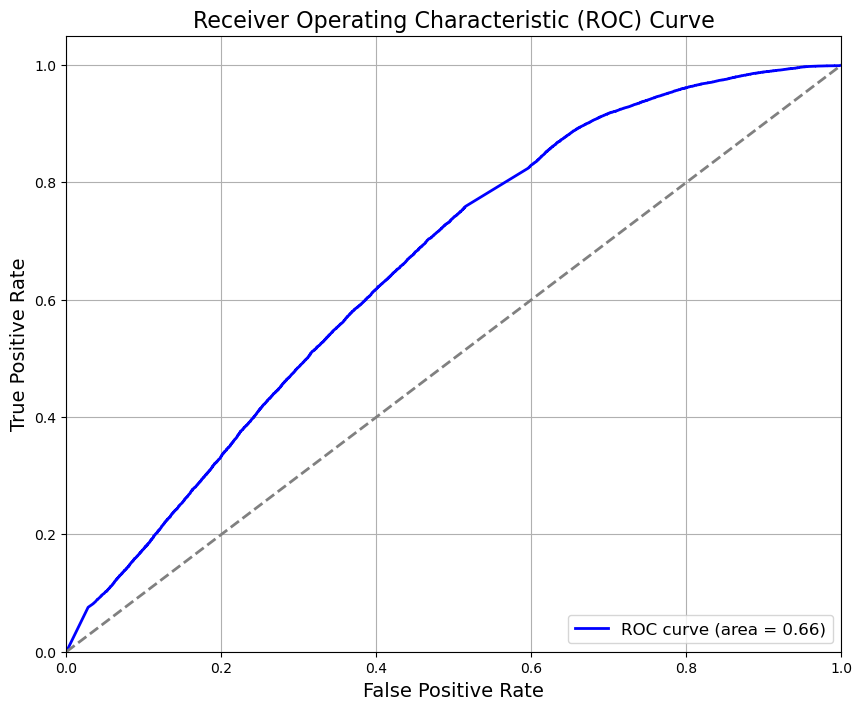

In [8]:
# ROC Curve and AUC
probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()

# Calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test_tensor.cpu(), probabilities)

# Calculate the AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_test_tensor.cpu(), probabilities)

# Plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()